In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import tweepy
import sys
from tweepy.streaming import StreamListener
import pymongo
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

### Twitter credentials

In [3]:
with open("twitter_credentials.json", "r") as file:
    creds = json.load(file)

In [4]:
auth = tweepy.OAuthHandler(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])
auth.set_access_token(creds['ACCESS_TOKEN'], creds['ACCESS_SECRET'])
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

### SteamListener

Se necesita sobre escribir la clase **StreamListener**

In [5]:
class MyStreamListener(StreamListener):
    def __init__(self, output_db):
        super(MyStreamListener,self).__init__()
        self.output = output_db
    
    #Method that will be called when a tweet is downloaded
    def on_status(self, status):
        self.output.insert_one(json.loads(json.dumps(status._json)))
    
    #Handles errors returned by the API
    """The Twitter API will send a 420 status code if we’re being rate limited. 
    If this happens, we’ll want to disconnect. If it’s any other error, we’ll keep going:"""
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_error disconnects the stream
            return False

#### Base de datos en mongo db

- Como instalar mongo_db: https://tecadmin.net/install-mongodb-on-ubuntu/
- Iniciarlo con **sudo service mongod start**
- **mongo**

In [6]:
client = pymongo.MongoClient()
db = client['db_tweets']
tweets_coll = db['bf_tweets']

In [7]:
output = open('output_tweets.txt', 'w')
myStreamListener = MyStreamListener(tweets_coll)
myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)

In [8]:
myStream.filter(track=['#WatermelonSugar'], is_async=True)

In [9]:
client = pymongo.MongoClient()
db = client['db_tweets']
tweets_coll = db['bf_tweets']

In [10]:
tweets_coll.count_documents({})

37812

In [11]:
status_sample = tweets_coll.find({})[0]

In [12]:
status_sample.keys()

dict_keys(['_id', 'created_at', 'id', 'id_str', 'text', 'source', 'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'retweeted_status', 'is_quote_status', 'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted', 'filter_level', 'lang', 'timestamp_ms'])

In [49]:
all_tweets = list(tweets_coll.find({}))
len(all_tweets)

39397

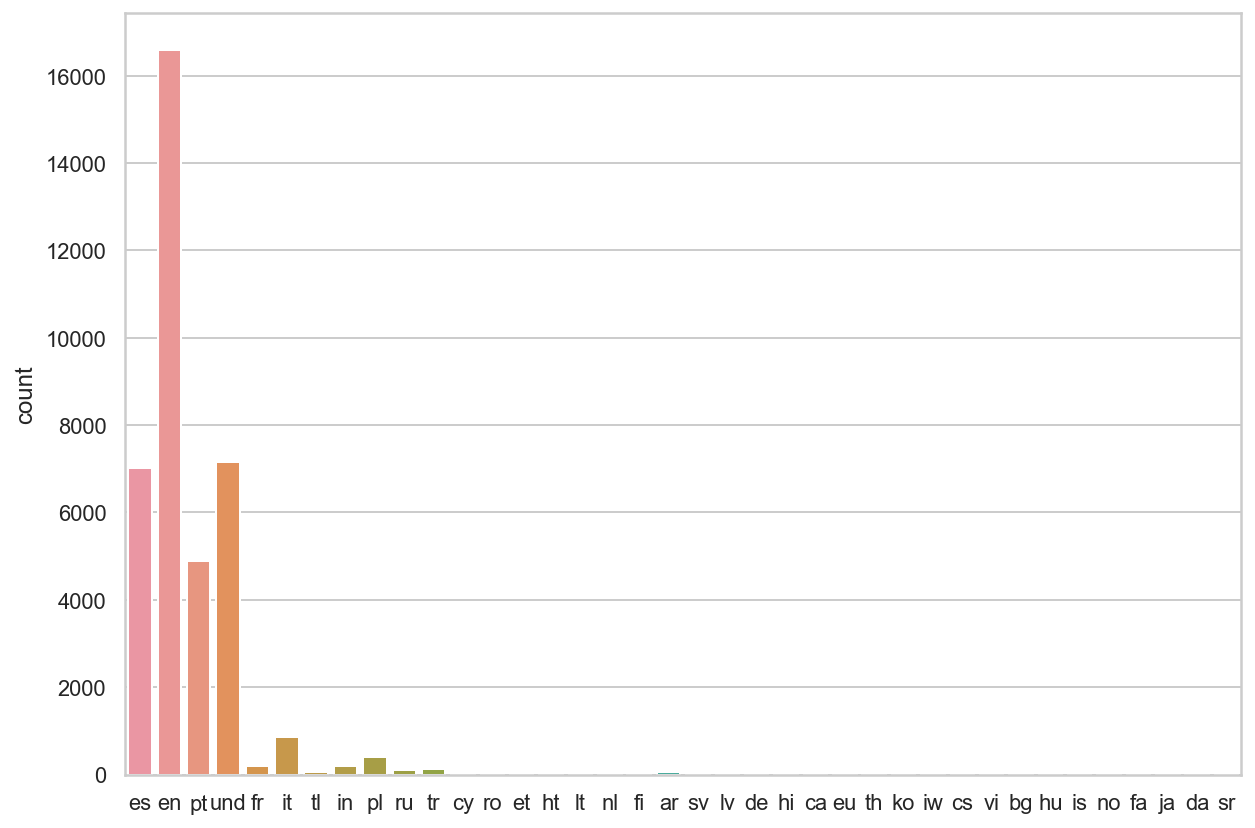

In [15]:
plt.figure(figsize=(10,7))
sns.countplot([tweet['lang'] for tweet in all_tweets])

In [63]:
all_tweets[0]['id']

1260626726226362368

In [16]:
import json
import pandas as pd
import re
# Convertir la respuesta del API a un dataframe
tweets = []
for result in all_tweets:
    tweet_dict = {}
    tweet_dict['id'] = result['id']
    tweet_dict['text'] = result['text']
    tweet_dict['truncated'] = result['truncated']
    tweet_dict['source'] = [re.findall('\>(.*?)\<', result['source'])[0] if result['source'] else ' ']
    tweet_dict['retweet_count'] = result['retweet_count']
    tweet_dict['favorite_count'] = result['favorite_count']
    tweets.append(tweet_dict)
df_tweets = pd.DataFrame(tweets)
df_tweets.shape

(37937, 6)

In [35]:
df_tweets.sample(20)

,id,text,truncated,source,retweet_count,favorite_count
4752,1260628183621046273,🍉🍉🍉🍉🍉🍉 #WatermelonSugar #WatermelonSugarMV htt...,False,[Twitter for Android],0,0
23252,1260647436155944962,@95hniall_ #WatermelonSugar,False,[Twitter for Android],0,0
37808,1260656491788292097,RT @maxregan71: Do you want to convert your im...,False,[Twitter Web App],0,0
20156,1260646002802868224,tengeneng #WatermelonSugar,False,[TengenengTrends],0,0
4184,1260628047499313154,RT @hsdaily: #WatermelonSugar. Coming Soon.🍉 h...,False,[Twitter for iPhone],0,0
30801,1260651205606293504,RT @haroldweloveyou: Eu si ven el video de WS ...,False,[Twitter for Android],0,0
36649,1260654826154688514,RT @latelateshow: but guys the #watermelonsuga...,False,[Twitter for iPhone],0,0
26327,1260648882356105216,RT @Jaz_Tomlinson25: ¿Ustedes entienden el pod...,False,[Twitter for Android],0,0
4635,1260628154898681856,RT @HarryS_Chile: ¿Alguien más estaba necesita...,False,[Twitter for Android],0,0
37227,1260655170767077376,RT @mysugarharry: Kiwi walked so watermelon su...,False,[Twitter for iPhone],0,0


In [56]:
import json
from bson import ObjectId

class JSONEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, ObjectId):
            return str(o)
        return json.JSONEncoder.default(self, o)

In [59]:
output.write(JSONEncoder().encode(all_tweets[0:200]))
output.close()

In [60]:
output = open('output_tweets.txt', 'r')
json2 = output.read()